In [1]:
import numpy as np
from functools import partial
import ipywidgets as widgets
from IPython.display import display

In [2]:
#pydrake imports
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import IrisOptions, IrisInRationalConfigurationSpace, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions
from pydrake.all import PiecewisePolynomial, InverseKinematics, Sphere, Rgba, RigidTransform, RotationMatrix, IrisInConfigurationSpace
import time
import pydrake

In [3]:
from ur3e_demo import UrDiagram, SetDiffuse
import ur3e_demo
import visualization_utils as viz_utils

/home/peter/git/drake_visiris_build/drake/C_Iris_Examples/ur3e_demo.py:28: DrakeDeprecationWarning: Please import from the pydrake.solvers module directly, instead of the deprecated pydrake.solvers.mathematicalprogram submodule. The deprecated code will be removed from Drake on or after 2023-05-01.
  from pydrake.solvers import mathematicalprogram as mp


In [4]:
bilinear_alt_result_file = "dual_ur3e_bil_alt_result.npz"
load_data = bilinear_alt_result_file
weld_wrist = False
with_gripper = True

In [5]:
ur = UrDiagram(num_ur = 1, weld_wrist = True, add_shelf = True,
                 add_gripper = True)
diagram_context = ur.diagram.CreateDefaultContext()
diagram = ur.diagram.ForcedPublish(diagram_context)

plant_context = ur.plant.GetMyMutableContextFromRoot(
        diagram_context)
scene_graph_context = ur.scene_graph.GetMyMutableContextFromRoot(
    diagram_context)
inspector = ur.scene_graph.model_inspector()        
        
# # construct the RationalForwardKinematics of this plant. This object handles the
# # computations for the forward kinematics in the tangent-configuration space
# Ratfk = RationalForwardKinematics(ur.plant)

# # the point about which we will take the stereographic projections
# q_star = np.zeros(ur.plant.num_positions())

# # The object we will use to perform our certification.
# cspace_free_polytope = CspaceFreePolytope(ur.plant, ur.scene_graph,
#                                           SeparatingPlaneOrder.kAffine, q_star)

INFO:drake:Meshcat listening for connections at http://localhost:7000


http://localhost:7000


In [6]:
sliders = []
for i in range(ur.plant.num_positions()):
    q_low = ur.plant.GetPositionLowerLimits()[i]
    q_high = ur.plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

q = np.zeros(ur.plant.num_positions())
ik = InverseKinematics(ur.plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)
def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5)   

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres(q)

def showres(qvis):
    ur.plant.SetPositions(plant_context, qvis)
    col = col_func_handle(qvis)
    shunk = ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    ur.meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    
    ur.diagram.ForcedPublish(diagram_context)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

display(sliders[0])
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q1', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q2', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q3', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q4', max=2.827433388230814, min=-2.827433388230814)

In [7]:
q

array([0., 0., 0., 0., 0.])

In [8]:
poi = []
poi.append(np.array([-0.32743, -0.92743,  0.47257,  0.07257, -0.02743]))
poi.append(np.array([-1.62743, -1.32743,  2.57257, -1.22743, -0.02743]))
poi.append(np.array([-1.62743, -2.02743,  1.67257,  0.37257, -0.02743]))
poi.append(np.array([-1.72743, -1.82743, -2.02743,  0.67257, -0.02743]))
poi.append(np.array([-1.72743, -1.92743,  1.07257, -2.32743, -0.02743]))
poi.append(np.array([-1.72743, -1.32743, -0.92743, -1.02743, -0.02743]))
poi.append(np.array([-1.52743, -2.42743,  0.87257, -1.62743, -0.02743]))
poi.append(np.array([-2.12743, -0.52743, -1.92743,  2.47257, -1.02743]))

In [9]:
snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 10
snopt_iris_options.configuration_space_margin = 1e-3
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = 5
snopt_iris_options.relative_termination_threshold = 0.02

def SNOPT_IRIS(q_seeds,  region_obstacles, logger, plant, context, snoptiris_options):
	regions = []
	for reg_indx, q_seed in enumerate(q_seeds):
		#q_seed = Ratforwardkin.ComputeQValue(s_seed.reshape(-1,1), np.zeros((7,1)))
		#print('snopt iris call')
		snoptiris_options.configuration_obstacles = []
		if len(region_obstacles):
			snoptiris_options.configuration_obstacles = region_obstacles
		plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
		try:
			#r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), q_star, snoptiris_options)
			r = IrisInConfigurationSpace(plant, plant_context, snoptiris_options)
			r_red = r.ReduceInequalities()
			print(f"[SNOPT IRIS]: Region:{reg_indx} / {len(q_seeds)}")
			#run the certifier
			# cert = cspace_free_polytope.BinarySearch(set(),
			# 								r.A(),
			# 								r.b(), 
			# 								np.array(s_seed),
			# 								binary_search_options)
			if logger is not None: logger.log_region(r_red)
			# r = cert.certified_polytope
			regions.append(r_red)
		except:
			print("error, SNOPT IRIS FAILED")
	return regions

SNOPT_IRIS_Handle = partial(SNOPT_IRIS,
                            plant = ur.plant,
                            context = diagram_context,
                            snoptiris_options = snopt_iris_options,
			    			#binary_search_options = binary_search_options,
                            #Ratforwardkin = Ratfk,
                            )

In [11]:
#setup visibility seeding helpers
from visibility_utils import point_in_regions
from tqdm import tqdm
from scipy.sparse import lil_matrix

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) #do you even geometry bro?
q_min = np.array(q_low)*scaler
q_max = np.array(q_high)*scaler
q_diff = q_max-q_min

alpha = 0.05
eps = 0.25
N = 1000
seed = 1
np.random.seed(seed)

def estimate_coverage(regions, pts = 3000):
	pts_ = [sample_cfree_QPoint() for _ in range(pts)]
	inreg = 0
	for pt in pts_:
		if point_in_regions(pt, regions): inreg+=1
	return inreg/pts

def sample_cfree_QPoint(MAXIT=1000):
	it = 0
	while it<MAXIT:
		rand = np.random.rand(5)
		q_s = q_min + rand*q_diff
		col = False
		for _ in range(10):
			r  = 0.05*(np.random.rand(5)-0.5)
			col |= (col_func_handle(q_s+r) > 0)
		if not col:
			return q_s #Ratfk.ComputeQValue(q_s, q_star)
		it+=1
	raise ValueError("no col free point found")

def sample_cfree_QPoint_in_regions(regions):
	for _ in range(1000):
		pt = sample_cfree_QPoint()
		if point_in_regions(pt, regions): return pt
	return None

def sample_cfree_handle(n, m, regions=None):
		points = np.zeros((n,5))
		if regions is None: regions = []		
		for i in range(n):
			bt_tries = 0
			while bt_tries<m:
				point = sample_cfree_QPoint()
				col = False
				for _ in range(10):
					r  = 0.05*(np.random.rand(5)-0.5)
					col |= point_in_regions(point+r, regions)
				if col:
					bt_tries += 1
					if bt_tries == m:
						return points, True 
				else:
					break
			points[i] = point
		return points, False

# def visSSpace(t1, t2, regions, num_checks, visualizer):
# 	t1flat = t1.reshape(-1)
# 	t2flat = t2.reshape(-1)
# 	if np.linalg.norm(t1-t2) < 1e-6:
# 		return (1-col_func_handle(Ratfk.ComputeQValue(t1flat, q_star)))>0
				
# 	tvec = np.linspace(0,1, num_checks)
# 	for t in tvec:
# 		tinterp = t1flat*t + (1-t)*t2flat
# 		if col_func_handle(Ratfk.ComputeQValue(tinterp, q_star)):
# 			return False
# 		elif point_in_regions(tinterp, regions):
# 			return False
# 	else:
# 		return True

def vis(q1, q2, regions, num_checks):
	q1flat = q1.reshape(-1)
	q2flat = q2.reshape(-1)
	if np.linalg.norm(q1-q2) < 1e-6:
		return (1-col_func_handle(q1))>0
				
	tvec = np.linspace(0,1, num_checks)
	for t in tvec:
		qinterp = q1flat*t + (1-t)*q2flat
		if col_func_handle(qinterp):
			return False
		elif point_in_regions(qinterp, regions):
			return False
	else:
		return True
    
visibility_checker = partial(vis, num_checks = 40)

def vgraph_builder(points, regions):
	n = len(points)
	adj_mat = lil_matrix((n,n))
	for i in tqdm(range(n)):
		point = points[i, :]
		for j in range(len(points[:i])):
			other = points[j]
			result = visibility_checker(point, other, regions)
			#print(result)
			if result:
				adj_mat[i,j] = adj_mat[j,i] = 1
	return adj_mat.toarray()

logdir created
[11:45:12] [VisSeeder] Point Insertion attempts M: 61
[11:45:12] [VisSeeder] 0.95 probability that unseen region is less than 15.0 '%' of Cfree 


100%|██████████| 1000/1000 [05:54<00:00,  2.82it/s]


[11:51:17] [VisSeeder] Found  57  hidden points
[SNOPT IRIS]: Region:0 / 57
[SNOPT IRIS]: Region:1 / 57
[SNOPT IRIS]: Region:2 / 57
[SNOPT IRIS]: Region:3 / 57
[SNOPT IRIS]: Region:4 / 57
[SNOPT IRIS]: Region:5 / 57
[SNOPT IRIS]: Region:6 / 57
[SNOPT IRIS]: Region:7 / 57
[SNOPT IRIS]: Region:8 / 57
[SNOPT IRIS]: Region:9 / 57
[SNOPT IRIS]: Region:10 / 57
[SNOPT IRIS]: Region:11 / 57
[SNOPT IRIS]: Region:12 / 57
[SNOPT IRIS]: Region:13 / 57
[SNOPT IRIS]: Region:14 / 57
[SNOPT IRIS]: Region:15 / 57
[SNOPT IRIS]: Region:16 / 57
[SNOPT IRIS]: Region:17 / 57
[SNOPT IRIS]: Region:18 / 57
[SNOPT IRIS]: Region:19 / 57
[SNOPT IRIS]: Region:20 / 57
[SNOPT IRIS]: Region:21 / 57
[SNOPT IRIS]: Region:22 / 57
[SNOPT IRIS]: Region:23 / 57
[SNOPT IRIS]: Region:24 / 57
[SNOPT IRIS]: Region:25 / 57
[SNOPT IRIS]: Region:26 / 57
[SNOPT IRIS]: Region:27 / 57
[SNOPT IRIS]: Region:28 / 57
[SNOPT IRIS]: Region:29 / 57
[SNOPT IRIS]: Region:30 / 57
[SNOPT IRIS]: Region:31 / 57
[SNOPT IRIS]: Region:32 / 57
[SNOP

100%|██████████| 1000/1000 [08:55<00:00,  1.87it/s]


[12:09:20] [VisSeeder] Found  111  hidden points
[SNOPT IRIS]: Region:0 / 111
[SNOPT IRIS]: Region:1 / 111
[SNOPT IRIS]: Region:2 / 111
[SNOPT IRIS]: Region:3 / 111
[SNOPT IRIS]: Region:4 / 111
[SNOPT IRIS]: Region:5 / 111
[SNOPT IRIS]: Region:6 / 111
[SNOPT IRIS]: Region:7 / 111
[SNOPT IRIS]: Region:8 / 111
[SNOPT IRIS]: Region:9 / 111
[SNOPT IRIS]: Region:10 / 111
[SNOPT IRIS]: Region:11 / 111
[SNOPT IRIS]: Region:12 / 111
[SNOPT IRIS]: Region:13 / 111
[SNOPT IRIS]: Region:14 / 111
[SNOPT IRIS]: Region:15 / 111
[SNOPT IRIS]: Region:16 / 111
error, SNOPT IRIS FAILED
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:19 / 111
[SNOPT IRIS]: Region:20 / 111
[SNOPT IRIS]: Region:21 / 111
[SNOPT IRIS]: Region:22 / 111
[SNOPT IRIS]: Region:23 / 111
[SNOPT IRIS]: Region:24 / 111
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:26 / 111
[SNOPT IRIS]: Region:27 / 111
[SNOPT IRIS]: Region:28 / 111
[SNOPT IRIS]: Region:29 / 111
[SNOPT IRIS]: Region:30 / 111
[SNOPT IRIS]: Region:31 / 111
[SNOPT IRIS]: Re

100%|██████████| 1000/1000 [13:33<00:00,  1.23it/s]


[12:50:28] [VisSeeder] Found  165  hidden points
[SNOPT IRIS]: Region:0 / 165
[SNOPT IRIS]: Region:1 / 165
[SNOPT IRIS]: Region:2 / 165
[SNOPT IRIS]: Region:3 / 165
[SNOPT IRIS]: Region:4 / 165
[SNOPT IRIS]: Region:5 / 165
[SNOPT IRIS]: Region:6 / 165
[SNOPT IRIS]: Region:7 / 165
[SNOPT IRIS]: Region:8 / 165
[SNOPT IRIS]: Region:9 / 165
[SNOPT IRIS]: Region:10 / 165
[SNOPT IRIS]: Region:11 / 165
[SNOPT IRIS]: Region:12 / 165
[SNOPT IRIS]: Region:13 / 165
[SNOPT IRIS]: Region:14 / 165
[SNOPT IRIS]: Region:15 / 165
[SNOPT IRIS]: Region:16 / 165
[SNOPT IRIS]: Region:17 / 165
[SNOPT IRIS]: Region:18 / 165
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:20 / 165
[SNOPT IRIS]: Region:21 / 165
[SNOPT IRIS]: Region:22 / 165
[SNOPT IRIS]: Region:23 / 165
[SNOPT IRIS]: Region:24 / 165
[SNOPT IRIS]: Region:25 / 165
[SNOPT IRIS]: Region:26 / 165
[SNOPT IRIS]: Region:27 / 165
[SNOPT IRIS]: Region:28 / 165
[SNOPT IRIS]: Region:29 / 165
[SNOPT IRIS]: Region:30 / 165
error, SNOPT IRIS FAILED
[SNOPT IRIS

100%|██████████| 1000/1000 [18:55<00:00,  1.14s/it]


[14:02:05] [VisSeeder] Found  207  hidden points
[SNOPT IRIS]: Region:0 / 207
[SNOPT IRIS]: Region:1 / 207
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:3 / 207
[SNOPT IRIS]: Region:4 / 207
[SNOPT IRIS]: Region:5 / 207
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:7 / 207
[SNOPT IRIS]: Region:8 / 207
[SNOPT IRIS]: Region:9 / 207
[SNOPT IRIS]: Region:10 / 207
[SNOPT IRIS]: Region:11 / 207
[SNOPT IRIS]: Region:12 / 207
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:14 / 207
[SNOPT IRIS]: Region:15 / 207
[SNOPT IRIS]: Region:16 / 207
[SNOPT IRIS]: Region:17 / 207
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:19 / 207
[SNOPT IRIS]: Region:20 / 207
[SNOPT IRIS]: Region:21 / 207
[SNOPT IRIS]: Region:22 / 207
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:24 / 207
[SNOPT IRIS]: Region:25 / 207
[SNOPT IRIS]: Region:26 / 207
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:28 / 207
[SNOPT IRIS]: Region:29 / 207
[SNOPT IRIS]: Region:30 / 207
[SNOPT IRIS]: Region:31 / 207
[SNOPT IRIS]: Region:32 / 207

100%|██████████| 1000/1000 [24:12<00:00,  1.45s/it]


[15:59:54] [VisSeeder] Found  241  hidden points
error, SNOPT IRIS FAILED
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:2 / 241
[SNOPT IRIS]: Region:3 / 241
[SNOPT IRIS]: Region:4 / 241
[SNOPT IRIS]: Region:5 / 241
[SNOPT IRIS]: Region:6 / 241
[SNOPT IRIS]: Region:7 / 241
[SNOPT IRIS]: Region:8 / 241
[SNOPT IRIS]: Region:9 / 241
[SNOPT IRIS]: Region:10 / 241
[SNOPT IRIS]: Region:11 / 241
[SNOPT IRIS]: Region:12 / 241
[SNOPT IRIS]: Region:13 / 241
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:15 / 241
[SNOPT IRIS]: Region:16 / 241
[SNOPT IRIS]: Region:17 / 241
[SNOPT IRIS]: Region:18 / 241
[SNOPT IRIS]: Region:19 / 241
[SNOPT IRIS]: Region:20 / 241
[SNOPT IRIS]: Region:21 / 241
[SNOPT IRIS]: Region:22 / 241
[SNOPT IRIS]: Region:23 / 241
[SNOPT IRIS]: Region:24 / 241
[SNOPT IRIS]: Region:25 / 241
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:27 / 241
[SNOPT IRIS]: Region:28 / 241
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:30 / 241
[SNOPT IRIS]: Region:31 / 241
[SNOPT IRIS]: Region:32 

100%|██████████| 1000/1000 [30:11<00:00,  1.81s/it]


[18:49:28] [VisSeeder] Found  269  hidden points
[SNOPT IRIS]: Region:0 / 269
[SNOPT IRIS]: Region:1 / 269
[SNOPT IRIS]: Region:2 / 269
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:4 / 269
[SNOPT IRIS]: Region:5 / 269
[SNOPT IRIS]: Region:6 / 269
[SNOPT IRIS]: Region:7 / 269
[SNOPT IRIS]: Region:8 / 269
[SNOPT IRIS]: Region:9 / 269
[SNOPT IRIS]: Region:10 / 269
[SNOPT IRIS]: Region:11 / 269
[SNOPT IRIS]: Region:12 / 269
[SNOPT IRIS]: Region:13 / 269
[SNOPT IRIS]: Region:14 / 269
[SNOPT IRIS]: Region:15 / 269
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:17 / 269
[SNOPT IRIS]: Region:18 / 269
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:20 / 269
[SNOPT IRIS]: Region:21 / 269
[SNOPT IRIS]: Region:22 / 269
[SNOPT IRIS]: Region:23 / 269
[SNOPT IRIS]: Region:24 / 269
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:26 / 269
[SNOPT IRIS]: Region:27 / 269
[SNOPT IRIS]: Region:28 / 269
error, SNOPT IRIS FAILED
[SNOPT IRIS]: Region:30 / 269
[SNOPT IRIS]: Region:31 / 269
[SNOPT IRIS]: Region:32 /

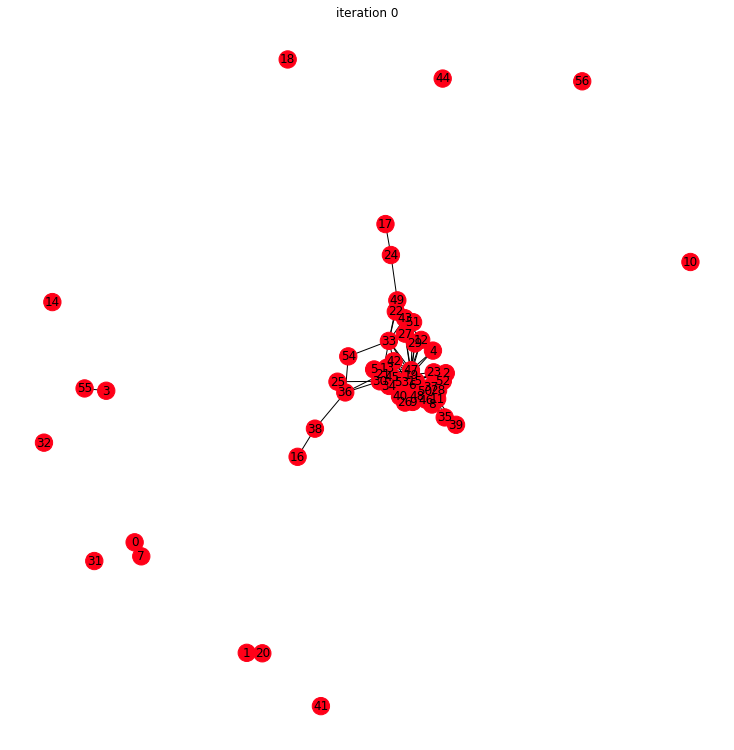

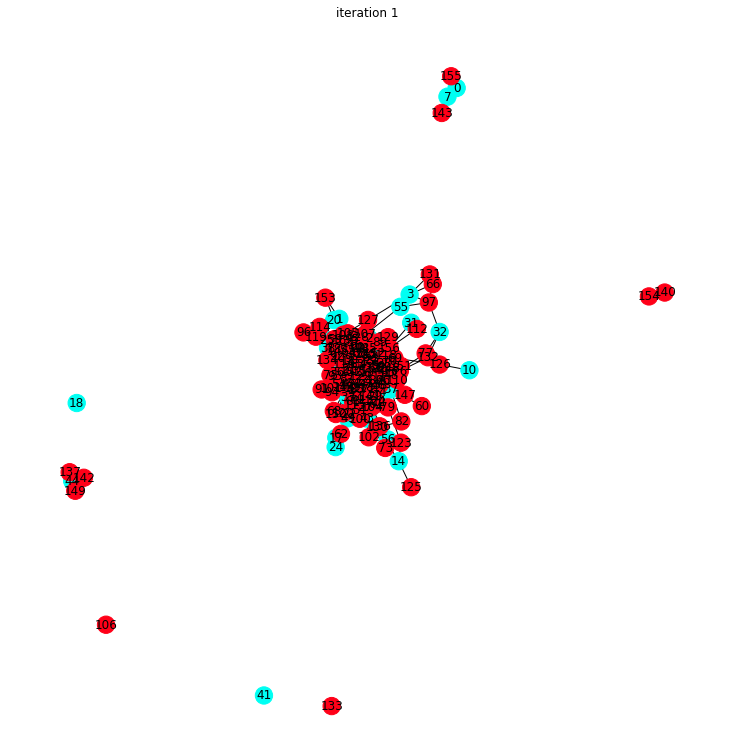

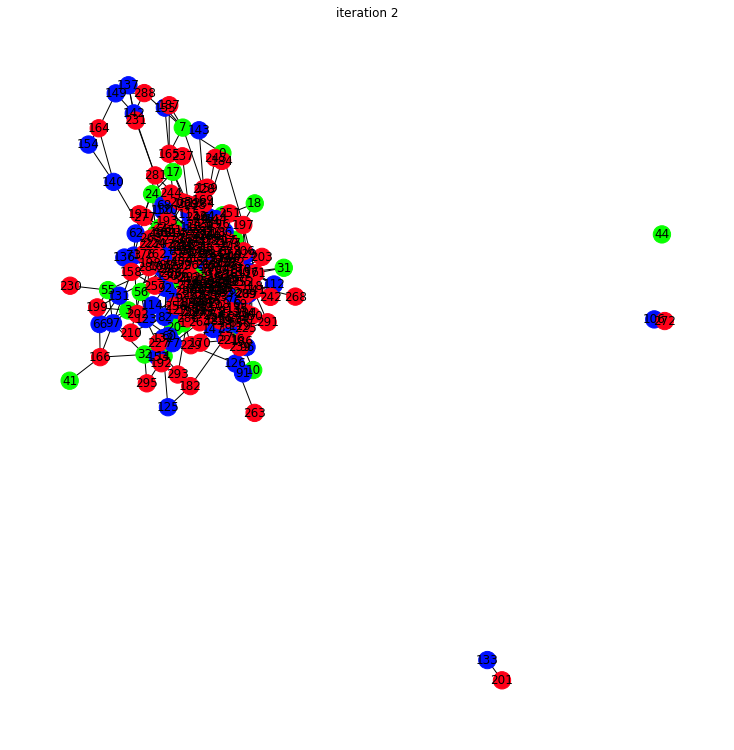

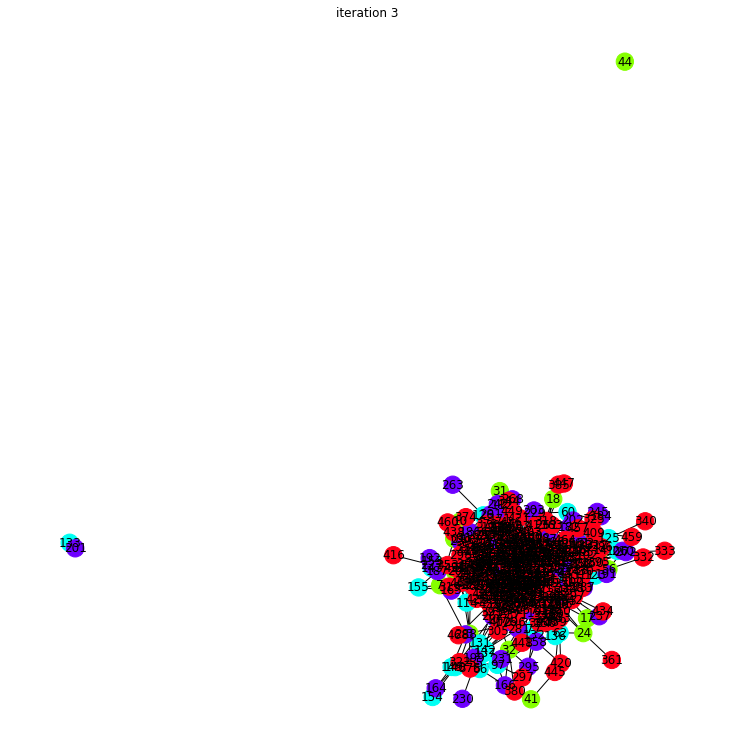

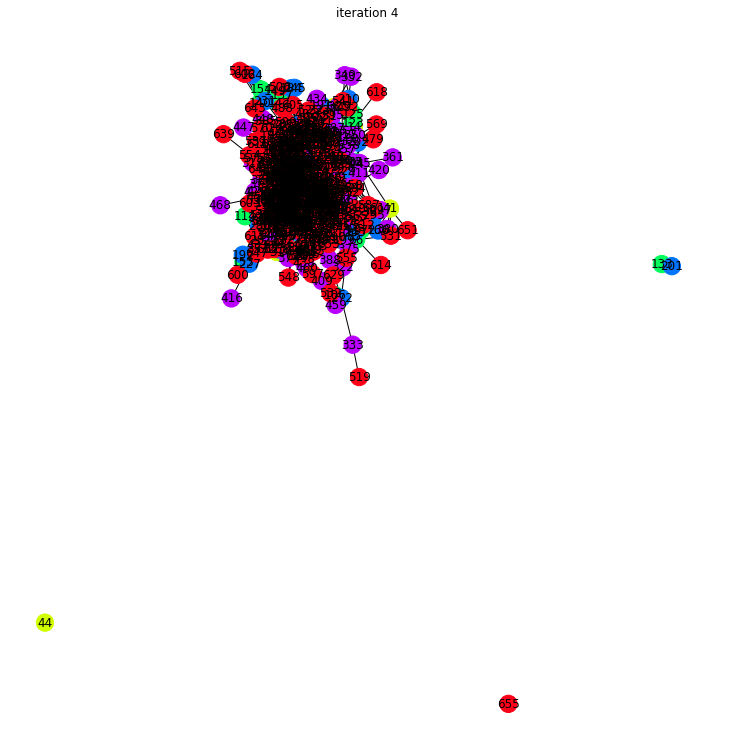

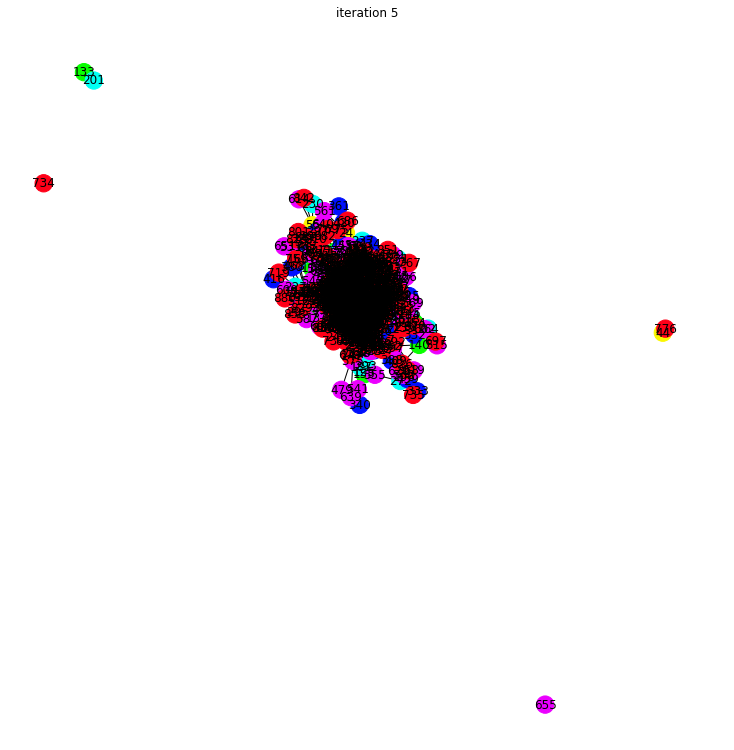

In [12]:
from visibility_seeding import VisSeeder
from visibility_logging import Logger
import os
LOAD_CHKPT = False
logger = Logger("5DOf_ur", seed, N, alpha, eps, estimate_coverage)
VS = VisSeeder(N = N,
            alpha = alpha,
            eps = eps,
            max_iterations = 10,
            sample_cfree = sample_cfree_handle,
            build_vgraph = vgraph_builder,
            iris_w_obstacles = SNOPT_IRIS_Handle,
            verbose = True,
            logger = logger
            )
if not LOAD_CHKPT:
    out = VS.run()
else:
    pass
    #exp_name = "7DOf_shelves_20230617114513_1_1000_0.050_0.200"
    #poly_names = os.listdir("logs/"+exp_name+"/regions")

In [11]:
r_poi = SNOPT_IRIS_Handle(poi, [], None) 

[SNOPT IRIS]: Region:0 / 8
[SNOPT IRIS]: Region:1 / 8
[SNOPT IRIS]: Region:2 / 8
[SNOPT IRIS]: Region:3 / 8
[SNOPT IRIS]: Region:4 / 8
[SNOPT IRIS]: Region:5 / 8
[SNOPT IRIS]: Region:6 / 8
[SNOPT IRIS]: Region:7 / 8


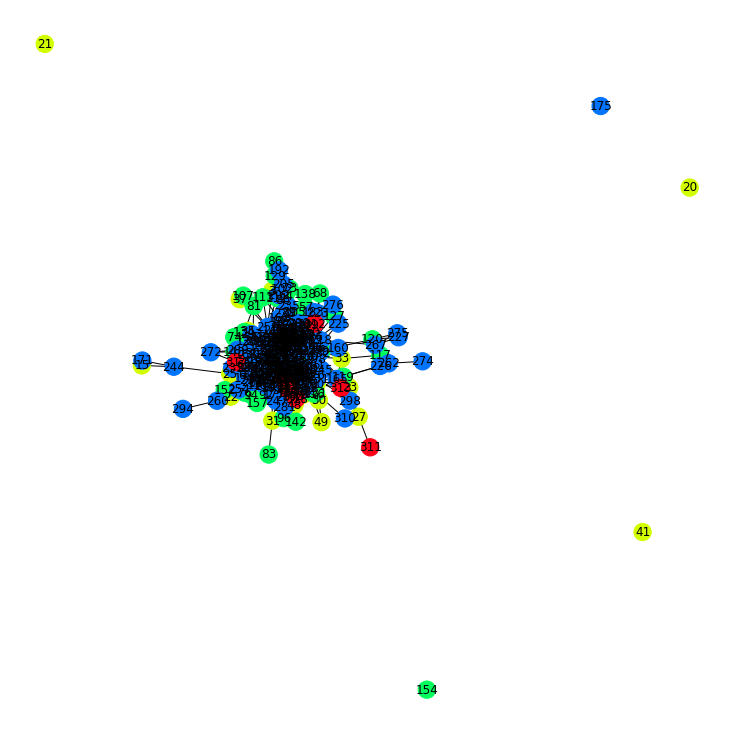

In [15]:
import pickle
import networkx as nx
from visibility_utils import generate_distinct_colors
import matplotlib.pyplot as plt
import os
exp_name = "5DOf_ur_20230617172407_1_1000_0.050_0.200"
poly_names = os.listdir("logs/"+exp_name+"/regions")
data_chkpts = os.listdir("logs/"+exp_name+"/data")
poly_names.sort()
data_chkpts.sort()
regions = []
for p in poly_names:
    with open("logs/"+exp_name+"/regions/"+p, 'rb') as f:
        d = pickle.load(f)
    regions.append(HPolyhedron(d['ra'], d['rb']))

with open("logs/"+exp_name+"/data/"+data_chkpts[-1], 'rb') as f:
    d = pickle.load(f)

region_groups_sizes = [len(g) for g in d['rb']]
len_reg = np.sum(region_groups_sizes) 
region_groups_sizes.append(len(regions)-len_reg)
region_groups = []
idx = 0
for s in region_groups_sizes:
    grp = []
    for i in range(s):
        grp.append(regions[i+idx])
    idx+=len(grp)
    region_groups.append(grp)

regions+=r_poi
region_groups.append(r_poi)
connectivity_graph = nx.Graph()
for idx in range(len(regions)):
    connectivity_graph.add_node(idx)
    
for idx1 in range(len(regions)):
    for idx2 in range(idx1 +1, len(regions)):
        r1 = regions[idx1]
        r2 = regions[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(len(region_groups)+1)[1:]
colors = []
for g, h in zip(region_groups, hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.show()

In [14]:
for p in poi:
    print(point_in_regions(p, regions))

False
True
False
False
False
False
False
False


In [21]:
#from pydrake.all import Box, GetVertices
query = ur.scene_graph.get_query_output_port().Eval(ur.scene_graph.GetMyContextFromRoot(diagram_context))
inspector = query.inspector()
a = inspector.GetCollisionCandidates()
geomids= []
for b, c in a:
    geomids.append(b)
    geomids.append(c)
ids = list(set(geomids))
frame_id_dict = {}
for idx in range(len(ids)):
    #print(idx, plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])))
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='body':
        frame_id_dict['body'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='left_finger':
        frame_id_dict['left_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='right_finger':
        frame_id_dict['right_finger'] = ids[idx]
print(frame_id_dict)
geom_ids = [inspector.GetGeometries(inspector.GetFrameId(frame_id_dict[k]))[0] for k in frame_id_dict.keys()]

sh_frames = [11,12,13]
sh_geom = [inspector.GetShape(id) for id in geom_ids] 
sh_names = ['box', 'l','r']
def plot_endeff_pose(q, name = '', color = Rgba(1,1,0.1,0.8)):
    ur.plant.SetPositions(plant_context, q)
    tfs = [ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(f))) for f in sh_frames]
    for n, f, geom in zip(sh_names, tfs, sh_geom):
        ur.meshcat.SetObject("/iris/shunk/"+name+"/"+n,
                                geom,
                                color)
        ur.meshcat.SetTransform("/iris/shunk/"+name+"/"+n, f)
for i,p in enumerate(poi):
    plot_endeff_pose(p, str(i))

{'body': <GeometryId value=79>, 'left_finger': <GeometryId value=85>, 'right_finger': <GeometryId value=91>}


In [31]:
def densify_waypoints(waypoints_q):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            ur.plant.SetPositions(plant_context, qa)
            tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        ur.plant.SetPositions(plant_context, qa)
        tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        ur.meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        ur.meshcat.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [ ]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions, conversion_dummy)

In [35]:
import time

start = poi[0]
for _ in range(50):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt = poi[np.random.choice(8)]
        if nxt[0] != start[0]:
            break
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for qa in dense_waypoints:
            #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
            showres(qa)
            #if col_func_handle(qa):
            #print(col)
            #break
            time.sleep(0.01)
        start = nxt
        time.sleep(0.01)
        ur.meshcat.Delete("/iris/points/traj/")
        
    else:
        nxt = poi[np.random.choice(12)]

[DijkstraSPP] optimized distance/ start-distance = 2.13 / 2.76 = 0.77
2.13074405546162
[DijkstraSPP] optimized distance/ start-distance = 7.02 / 8.63 = 0.81
7.018355286033547
[DijkstraSPP] optimized distance/ start-distance = 7.65 / 9.43 = 0.81
7.652379950190703
[DijkstraSPP] optimized distance/ start-distance = 6.26 / 7.84 = 0.80
6.263945866671576
[DijkstraSPP] optimized distance/ start-distance = 6.47 / 7.45 = 0.87
6.4702025615116305
[DijkstraSPP] optimized distance/ start-distance = 4.29 / 6.62 = 0.65
4.2873561528351
[DijkstraSPP] optimized distance/ start-distance = 5.19 / 7.68 = 0.68
5.186091878395635
[DijkstraSPP] optimized distance/ start-distance = 4.59 / 6.81 = 0.67
4.588126271921921
[DijkstraSPP] optimized distance/ start-distance = 3.52 / 4.89 = 0.72
3.5212626910848384
[DijkstraSPP] optimized distance/ start-distance = 7.69 / 10.64 = 0.72
7.6941402099992935
[DijkstraSPP] optimized distance/ start-distance = 4.38 / 8.53 = 0.51
4.377303915606777
[DijkstraSPP] optimized distanc